   # Transfer learning pytorch course with ResNet 

## Preparing Data

### Data augmentation

In [1]:
import torch
import torch.nn as nn
import torchvision 
from torchvision import datasets, models, transforms
import os 
import numpy as np

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Data load

In [3]:
data_dir = "/kaggle/input/hymenoptera-data/hymenoptera_data"
# Create the datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train','val']}
# Create the data loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}
#create a dic that containe the size 
dataset_size = {x: len(image_datasets[x]) for x in ['train', 'val']}
# get the class name 
class_names = image_datasets['train'].classes
# Print the results
print(f"Class names: {class_names}")
print(f"There are {len(dataloaders['train'])} batches in the training set")
print(f"There are {len(dataloaders['val'])} batches in the test set")
print(f"there are {dataset_size['train']} training images")
print(f"there are {dataset_size['val']} test images")

Class names: ['ants', 'bees']
There are 61 batches in the training set
There are 39 batches in the test set
there are 244 training images
there are 153 test images


## load the Model

In [4]:
# Load the model 
model_conv = torchvision.models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


In [5]:
# Freeze all layers in the model
for param in model_conv.parameters():
    param.requires_grad = False

In [6]:
# Get the num of inputs of the last layer 
num_ftrs = model_conv.fc.in_features
# Reconstruct the last layer to only have 2 classes 
model_conv.fc = nn.Linear(num_ftrs, 2)

In [7]:
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [8]:
# Understanding what is happening 
iteration = 0
correct = 0

for inputs, labels in dataloaders['train']:
    if iteration == 1:
        break
        
    inputs = torch.autograd.Variable(inputs)
    labels = torch.autograd.Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    print("For one iterations this is what happens")
    print(f"Inputs shape {inputs.shape}")
    print(f"Labels shape {labels.shape}")
    print(f"Labels are {labels}")
    output = model_conv(inputs)
    print(f"The output tensor are : {output}")
    print(f"The outputs shape is : {output.shape}")
    _, predicted = torch.max(output,1)
    print(f"The predicteds are: {predicted}")
    print(f"The predicted shape is: {predicted.shape}")
    correct += (predicted == labels).sum()
    print(f"Correct prediction: {correct}")
    
    iteration +=1

For one iterations this is what happens
Inputs shape torch.Size([4, 3, 224, 224])
Labels shape torch.Size([4])
Labels are tensor([1, 0, 0, 0], device='cuda:0')
The output tensor are : tensor([[ 0.4487, -0.4107],
        [ 0.5281, -0.5615],
        [ 0.7133, -0.4723],
        [ 0.6581, -0.9920]], device='cuda:0', grad_fn=<AddmmBackward0>)
The outputs shape is : torch.Size([4, 2])
The predicteds are: tensor([0, 0, 0, 0], device='cuda:0')
The predicted shape is: torch.Size([4])
Correct prediction: 3


## Define the loss and the optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [10]:
num_epochs = 50 
for epoch in range(num_epochs):
        exp_lr_scheduler.step()
        correct = 0
        for images, labels in dataloaders['train']:
            
            images = torch.autograd.Variable(images)
            labels = torch.autograd.Variable(labels)
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = model_conv(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            
            correct += (predicted == labels).sum()
        
        train_acc = 100 * correct/dataset_size['train']
        print(f"Epoch :{epoch}/{num_epochs}, Loss :{loss.item()}, Train Accuracy : {train_acc}")
            

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch :0/50, Loss :0.0948246493935585, Train Accuracy : 66.80327606201172
Epoch :1/50, Loss :1.8635860681533813, Train Accuracy : 75.40982818603516
Epoch :2/50, Loss :0.29974818229675293, Train Accuracy : 74.59015655517578
Epoch :3/50, Loss :0.10556916892528534, Train Accuracy : 79.91802978515625
Epoch :4/50, Loss :0.5927026271820068, Train Accuracy : 74.99999237060547
Epoch :5/50, Loss :0.12469735741615295, Train Accuracy : 81.14753723144531
Epoch :6/50, Loss :0.8611879348754883, Train Accuracy : 76.22950744628906
Epoch :7/50, Loss :0.24024713039398193, Train Accuracy : 82.37704467773438
Epoch :8/50, Loss :0.19396571815013885, Train Accuracy : 82.78688049316406
Epoch :9/50, Loss :1.2441147565841675, Train Accuracy : 81.14753723144531
Epoch :10/50, Loss :0.13416005671024323, Train Accuracy : 83.19671630859375
Epoch :11/50, Loss :0.5194608569145203, Train Accuracy : 82.78688049316406
Epoch :12/50, Loss :0.055254947394132614, Train Accuracy : 85.65573120117188
Epoch :13/50, Loss :0.52855

## Test phase 

In [11]:
# Testing the model 
model_conv.eval()
with torch.no_grad():
    correct = 0 
    total = 0 
    for (images, labels) in dataloaders['val']:
        images = torch.autograd.Variable(images)
        labels = torch.autograd.Variable(labels)
        
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
        outputs = model_conv(images)
        _,predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print(f"Test accuracy: {100*correct/total}")
        

Test accuracy: 94.77124183006536


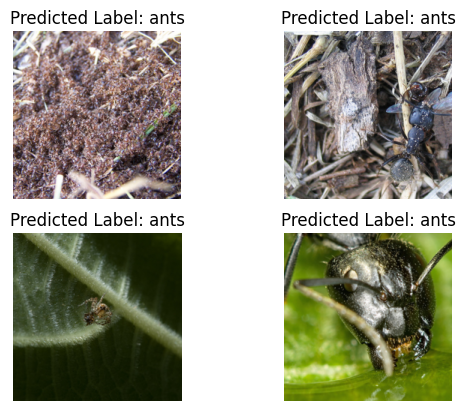

In [12]:
#Visualize some predictions 
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in dataloaders['val']:
        if shown_batch == 1:
            break
        shown_batch += 1
        images = torch.autograd.Variable(images)
        labels = torch.autograd.Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        outputs = model_conv(images)                            #The output is of shape (4,2)
        _, preds = torch.max(outputs, 1)                        #The pred is of shape (4) --> [ 0,  0,  0,  1]
        
        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[preds[i]]))
            input_img = images.cpu().data[i]                    #Get the tensor of the image, and put it to cpu  
            inp = input_img.numpy().transpose((1, 2, 0))        #If we have a tensor of shape (2,3,4) --> it becomes (3,4,2)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            inp = std * inp + mean
            inp = np.clip(inp, 0, 1)
            plt.imshow(inp)